<a href="https://colab.research.google.com/github/dvd42/Classification_Model-SVM-Logistic_Regression-/blob/master/W14_01_Metric_Learning_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


In [3]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [5]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [6]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.ReLU(),
                                nn.Linear(256, 256),
                                nn.ReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)


class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.ReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [5]:
def train_epoch(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if target is not None:
            target = target.to(device)

        data = tuple(d.to(device) for d in data)

        optimizer.zero_grad()

        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = outputs[0].max(1)[1]
        correct += pred.eq(target[0].view_as(pred)).sum().item()

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
            

        data = tuple(d.to(device) for d in data)

        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)
        loss_inputs = outputs
        if target is not None:
            target = (target.to(device),)
            loss_inputs += target

        pred = outputs[0].max(1)[1]
        correct += pred.eq(target[0].view_as(pred)).sum().item()

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        val_loss += loss.item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [10]:
embedding_net = EmbeddingNet().to(device)
n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)
loss_fn = torch.nn.NLLLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [ ]:
  for epoch in range(n_epochs):
       
        # Train stage
        train_loss, acc = train_epoch(train_loader, model, loss_fn, optimizer)
        scheduler.step()
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

        val_loss, acc = test_epoch(test_loader, model, loss_fn)
        val_loss /= len(test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss, acc)

        print(message)

Epoch: 1/10. Train set: Average loss: 2.3323 Accuracy: 9.76
Epoch: 1/10. Validation set: Average loss: 2.3028 Accuracy: 10.00
Epoch: 2/10. Train set: Average loss: 2.3031 Accuracy: 9.84
Epoch: 2/10. Validation set: Average loss: 2.3027 Accuracy: 10.00
Epoch: 3/10. Train set: Average loss: 2.3031 Accuracy: 9.98
Epoch: 3/10. Validation set: Average loss: 2.3030 Accuracy: 10.00
Epoch: 4/10. Train set: Average loss: 2.3031 Accuracy: 10.01
Epoch: 4/10. Validation set: Average loss: 2.3029 Accuracy: 10.00
Epoch: 5/10. Train set: Average loss: 2.3031 Accuracy: 9.92
Epoch: 5/10. Validation set: Average loss: 2.3031 Accuracy: 10.00
Epoch: 6/10. Train set: Average loss: 2.3030 Accuracy: 9.95
Epoch: 6/10. Validation set: Average loss: 2.3028 Accuracy: 10.00


KeyboardInterrupt: ignored

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [11]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.targets
            self.train_data = self.mnist_dataset.data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.targets
            self.test_data = self.mnist_dataset.data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

        
    def __len__(self):
        return len(self.mnist_dataset)

In [12]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [13]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [14]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)

batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [ ]:
for epoch in range(n_epochs):

        # Train stage
        train_loss, acc = train_epoch(siamese_train_loader, model, loss_fn, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        val_loss, acc = test_epoch(siamese_test_loader, model, loss_fn)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)

        print(message)

Epoch: 1/10. Train set: Average loss: 0.0496
Epoch: 1/10. Validation set: Average loss: 0.0421
Epoch: 2/10. Train set: Average loss: 0.0378
Epoch: 2/10. Validation set: Average loss: 0.0392
Epoch: 3/10. Train set: Average loss: 0.0335
Epoch: 3/10. Validation set: Average loss: 0.0354


KeyboardInterrupt: ignored

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Triplet Loss


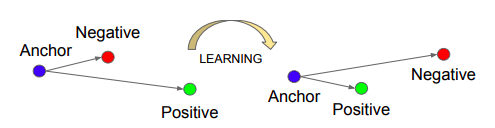

There are couple of problems with siamese and triplet networks.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

# Homework

A) Train FashionMNIST using a semi-hard Triplet Mining strategy, visualize the embeddings and comment what you observe. What are we trying to optimize? Does the criteria we are trying to optimize matches the results observed in the visualization?

Hints: You do not have to implement any Miner or Distance or anything of the sort. [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) implements everything we need.

Check the imports in the cell below for clues on what modules to use

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it. The general template usage is something like this:


```
from pytorch_metric_learning import miners, losses
miner = miners.MultiSimilarityMiner()
loss_func = losses.TripletMarginLoss()

# your training loop
for i, (data, labels) in enumerate(dataloader):
	optimizer.zero_grad()
	embeddings = model(data)
	hard_pairs = miner(embeddings, labels)
	loss = loss_func(embeddings, labels, hard_pairs)
	loss.backward()
	optimizer.step()
```

B) Explain the difference between semi-hard, easy and hard triplets. Try training with all of the type of triplets mentioned above and comment on the effect they have on training, using loss curves and other evidence you find necessary.

Solution here: https://kevinmusgrave.github.io/pytorch-metric-learning/miners/#tripletmarginminer

C) Find a way to **quantitatively** measure how good the embeddings are. 

D) Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE. The T-SNE library is installed in the cell below check the [github repo](https://github.com/DmitryUlyanov/Multicore-TSNE) for info on how to use it. Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few**



In [7]:
!pip install pytorch-metric-learning faiss-gpu
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


# THIS FUNCTION MIGHT BE USEFUL FOR C)
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

     |████████████████████████████████| 112kB 4.1MB/s 
     |████████████████████████████████| 89.4MB 34kB/s 


In [ ]:
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_components=2, verbose=1, n_jobs=2)

B) Semi-Hard: the negative is further from the anchor than the positive
   Hard: the negative is closer to the anchor than the positive
   Easy: triplets that do not violate the margin

   The miner is tasked with building the triplets for each mini-batch

Epoch 1 Iteration 0: Loss = 0.0, Number of mined triplets = 3292
Epoch 1 Iteration 20: Loss = 0.0, Number of mined triplets = 656
Epoch 1 Iteration 40: Loss = 0.0, Number of mined triplets = 2660
Epoch 1 Iteration 60: Loss = 0.0, Number of mined triplets = 2997
Epoch 1 Iteration 80: Loss = 0.0, Number of mined triplets = 1835
Epoch 1 Iteration 100: Loss = 0.0, Number of mined triplets = 572
Epoch 1 Iteration 120: Loss = 0.0, Number of mined triplets = 1846
Epoch 1 Iteration 140: Loss = 0.0, Number of mined triplets = 1565
Epoch 1 Iteration 160: Loss = 0.0, Number of mined triplets = 5031
Epoch 1 Iteration 180: Loss = 0.0, Number of mined triplets = 2066
Epoch 1 Iteration 200: Loss = 0.0, Number of mined triplets = 1967
Epoch 1 Iteration 220: Loss = 0.0, Number of mined triplets = 4259


100%|██████████| 313/313 [00:02<00:00, 117.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 2 Iteration 0: Loss = 0.0, Number of mined triplets = 3904
Epoch 2 Iteration 20: Loss = 0.0, Number of mined triplets = 737
Epoch 2 Iteration 40: Loss = 0.0, Number of mined triplets = 4812
Epoch 2 Iteration 60: Loss = 0.0, Number of mined triplets = 1414
Epoch 2 Iteration 80: Loss = 0.0, Number of mined triplets = 2232
Epoch 2 Iteration 100: Loss = 0.0, Number of mined triplets = 2261
Epoch 2 Iteration 120: Loss = 0.0, Number of mined triplets = 2002
Epoch 2 Iteration 140: Loss = 0.0, Number of mined triplets = 1142
Epoch 2 Iteration 160: Loss = 0.0, Number of mined triplets = 2381
Epoch 2 Iteration 180: Loss = 0.0, Number of mined triplets = 531
Epoch 2 Iteration 200: Loss = 0.0, Number of mined triplets = 7556
Epoch 2 Iteration 220: Loss = 0.0, Number of mined triplets = 2707


100%|██████████| 313/313 [00:02<00:00, 120.17it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 3 Iteration 0: Loss = 0.0, Number of mined triplets = 4011
Epoch 3 Iteration 20: Loss = 0.0, Number of mined triplets = 402
Epoch 3 Iteration 40: Loss = 0.0, Number of mined triplets = 373
Epoch 3 Iteration 60: Loss = 0.0, Number of mined triplets = 2533
Epoch 3 Iteration 80: Loss = 0.0, Number of mined triplets = 990
Epoch 3 Iteration 100: Loss = 0.0, Number of mined triplets = 682
Epoch 3 Iteration 120: Loss = 0.0, Number of mined triplets = 264
Epoch 3 Iteration 140: Loss = 0.0, Number of mined triplets = 1426
Epoch 3 Iteration 160: Loss = 0.0, Number of mined triplets = 1269
Epoch 3 Iteration 180: Loss = 0.0, Number of mined triplets = 2040
Epoch 3 Iteration 200: Loss = 0.0, Number of mined triplets = 5473
Epoch 3 Iteration 220: Loss = 0.0, Number of mined triplets = 769


100%|██████████| 313/313 [00:02<00:00, 122.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 4 Iteration 0: Loss = 0.0, Number of mined triplets = 1074
Epoch 4 Iteration 20: Loss = 0.0, Number of mined triplets = 496
Epoch 4 Iteration 40: Loss = 0.0, Number of mined triplets = 1072
Epoch 4 Iteration 60: Loss = 0.0, Number of mined triplets = 2617
Epoch 4 Iteration 80: Loss = 0.0, Number of mined triplets = 2557
Epoch 4 Iteration 100: Loss = 0.0, Number of mined triplets = 4093
Epoch 4 Iteration 120: Loss = 0.0, Number of mined triplets = 2056
Epoch 4 Iteration 140: Loss = 0.0, Number of mined triplets = 2189
Epoch 4 Iteration 160: Loss = 0.0, Number of mined triplets = 1675
Epoch 4 Iteration 180: Loss = 0.0, Number of mined triplets = 2450
Epoch 4 Iteration 200: Loss = 0.0, Number of mined triplets = 1978
Epoch 4 Iteration 220: Loss = 0.0, Number of mined triplets = 3200


100%|██████████| 313/313 [00:02<00:00, 118.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 5 Iteration 0: Loss = 0.0, Number of mined triplets = 3537
Epoch 5 Iteration 20: Loss = 0.0, Number of mined triplets = 4425
Epoch 5 Iteration 40: Loss = 0.0, Number of mined triplets = 4410
Epoch 5 Iteration 60: Loss = 0.0, Number of mined triplets = 982
Epoch 5 Iteration 80: Loss = 0.0, Number of mined triplets = 3461
Epoch 5 Iteration 100: Loss = 0.0, Number of mined triplets = 1902
Epoch 5 Iteration 120: Loss = 0.0, Number of mined triplets = 5287
Epoch 5 Iteration 140: Loss = 0.0, Number of mined triplets = 3936
Epoch 5 Iteration 160: Loss = 0.0, Number of mined triplets = 1897
Epoch 5 Iteration 180: Loss = 0.0, Number of mined triplets = 3081
Epoch 5 Iteration 200: Loss = 0.0, Number of mined triplets = 855
Epoch 5 Iteration 220: Loss = 0.0, Number of mined triplets = 2674


100%|██████████| 313/313 [00:02<00:00, 121.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 6 Iteration 0: Loss = 0.0, Number of mined triplets = 2703
Epoch 6 Iteration 20: Loss = 0.0, Number of mined triplets = 3126
Epoch 6 Iteration 40: Loss = 0.0, Number of mined triplets = 1230
Epoch 6 Iteration 60: Loss = 0.0, Number of mined triplets = 4027
Epoch 6 Iteration 80: Loss = 0.0, Number of mined triplets = 1746
Epoch 6 Iteration 100: Loss = 0.0, Number of mined triplets = 3101
Epoch 6 Iteration 120: Loss = 0.0, Number of mined triplets = 963
Epoch 6 Iteration 140: Loss = 0.0, Number of mined triplets = 5293
Epoch 6 Iteration 160: Loss = 0.0, Number of mined triplets = 765
Epoch 6 Iteration 180: Loss = 0.0, Number of mined triplets = 1263
Epoch 6 Iteration 200: Loss = 0.0, Number of mined triplets = 1936
Epoch 6 Iteration 220: Loss = 0.0, Number of mined triplets = 2718


100%|██████████| 313/313 [00:02<00:00, 122.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 7 Iteration 0: Loss = 0.0, Number of mined triplets = 2465
Epoch 7 Iteration 20: Loss = 0.0, Number of mined triplets = 1648
Epoch 7 Iteration 40: Loss = 0.0, Number of mined triplets = 679
Epoch 7 Iteration 60: Loss = 0.0, Number of mined triplets = 2989
Epoch 7 Iteration 80: Loss = 0.0, Number of mined triplets = 754
Epoch 7 Iteration 100: Loss = 0.0, Number of mined triplets = 910
Epoch 7 Iteration 120: Loss = 0.0, Number of mined triplets = 295
Epoch 7 Iteration 140: Loss = 0.0, Number of mined triplets = 2553
Epoch 7 Iteration 160: Loss = 0.0, Number of mined triplets = 4627
Epoch 7 Iteration 180: Loss = 0.0, Number of mined triplets = 1624
Epoch 7 Iteration 200: Loss = 0.0, Number of mined triplets = 1721
Epoch 7 Iteration 220: Loss = 0.0, Number of mined triplets = 2701


100%|██████████| 313/313 [00:02<00:00, 122.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 8 Iteration 0: Loss = 0.0, Number of mined triplets = 842
Epoch 8 Iteration 20: Loss = 0.0, Number of mined triplets = 816
Epoch 8 Iteration 40: Loss = 0.0, Number of mined triplets = 2215
Epoch 8 Iteration 60: Loss = 0.0, Number of mined triplets = 3416
Epoch 8 Iteration 80: Loss = 0.0, Number of mined triplets = 465
Epoch 8 Iteration 100: Loss = 0.0, Number of mined triplets = 1716
Epoch 8 Iteration 120: Loss = 0.0, Number of mined triplets = 1924
Epoch 8 Iteration 140: Loss = 0.0, Number of mined triplets = 4025
Epoch 8 Iteration 160: Loss = 0.0, Number of mined triplets = 1338
Epoch 8 Iteration 180: Loss = 0.0, Number of mined triplets = 2119
Epoch 8 Iteration 200: Loss = 0.0, Number of mined triplets = 1779
Epoch 8 Iteration 220: Loss = 0.0, Number of mined triplets = 1663


100%|██████████| 313/313 [00:02<00:00, 119.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 9 Iteration 0: Loss = 0.0, Number of mined triplets = 1706
Epoch 9 Iteration 20: Loss = 0.0, Number of mined triplets = 862
Epoch 9 Iteration 40: Loss = 0.0, Number of mined triplets = 2346
Epoch 9 Iteration 60: Loss = 0.0, Number of mined triplets = 4348
Epoch 9 Iteration 80: Loss = 0.0, Number of mined triplets = 5122
Epoch 9 Iteration 100: Loss = 0.0, Number of mined triplets = 1729
Epoch 9 Iteration 120: Loss = 0.0, Number of mined triplets = 3076
Epoch 9 Iteration 140: Loss = 0.0, Number of mined triplets = 7022
Epoch 9 Iteration 160: Loss = 0.0, Number of mined triplets = 822
Epoch 9 Iteration 180: Loss = 0.0, Number of mined triplets = 5407
Epoch 9 Iteration 200: Loss = 0.0, Number of mined triplets = 818
Epoch 9 Iteration 220: Loss = 0.0, Number of mined triplets = 1922


100%|██████████| 313/313 [00:02<00:00, 119.61it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 10 Iteration 0: Loss = 0.0, Number of mined triplets = 919
Epoch 10 Iteration 20: Loss = 0.0, Number of mined triplets = 2407
Epoch 10 Iteration 40: Loss = 0.0, Number of mined triplets = 292
Epoch 10 Iteration 60: Loss = 0.0, Number of mined triplets = 1343
Epoch 10 Iteration 80: Loss = 0.0, Number of mined triplets = 5022
Epoch 10 Iteration 100: Loss = 0.0, Number of mined triplets = 3183
Epoch 10 Iteration 120: Loss = 0.0, Number of mined triplets = 2354
Epoch 10 Iteration 140: Loss = 0.0, Number of mined triplets = 3062
Epoch 10 Iteration 160: Loss = 0.0, Number of mined triplets = 1615
Epoch 10 Iteration 180: Loss = 0.0, Number of mined triplets = 1482
Epoch 10 Iteration 200: Loss = 0.0, Number of mined triplets = 339
Epoch 10 Iteration 220: Loss = 0.0, Number of mined triplets = 4203


100%|██████████| 313/313 [00:02<00:00, 120.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1849
Epoch 1 Iteration 0: Loss = 0.21141812205314636, Number of mined triplets = 494361
Epoch 1 Iteration 20: Loss = 0.20000004768371582, Number of mined triplets = 1017796
Epoch 1 Iteration 40: Loss = 0.20000003278255463, Number of mined triplets = 945365
Epoch 1 Iteration 60: Loss = 0.20000004768371582, Number of mined triplets = 905689
Epoch 1 Iteration 80: Loss = 0.20000006258487701, Number of mined triplets = 971225
Epoch 1 Iteration 100: Loss = 0.20000003278255463, Number of mined triplets = 923735
Epoch 1 Iteration 120: Loss = 0.20000003278255463, Number of mined triplets = 889842
Epoch 1 Iteration 140: Loss = 0.20000004768371582, Number of mined triplets = 916113
Epoch 1 Iteration 160: Loss = 0.20000003278255463, Number of mined triplets = 884403
Epoch 1 Iteration 180: Loss = 0.20000003278255463, Number of mined triplets = 885560
Epoch 1 Iteration 200: Loss = 0.20000004768371582, Number of mined triplets = 883378
Epoch 1 It

100%|██████████| 313/313 [00:02<00:00, 120.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2039
Epoch 2 Iteration 0: Loss = 0.20000006258487701, Number of mined triplets = 793364
Epoch 2 Iteration 20: Loss = 0.20000003278255463, Number of mined triplets = 828742
Epoch 2 Iteration 40: Loss = 0.20000003278255463, Number of mined triplets = 845630
Epoch 2 Iteration 60: Loss = 0.20000003278255463, Number of mined triplets = 786117
Epoch 2 Iteration 80: Loss = 0.20000004768371582, Number of mined triplets = 763103
Epoch 2 Iteration 100: Loss = 0.20000006258487701, Number of mined triplets = 829773
Epoch 2 Iteration 120: Loss = 0.20000003278255463, Number of mined triplets = 736434
Epoch 2 Iteration 140: Loss = 0.20000004768371582, Number of mined triplets = 747355
Epoch 2 Iteration 160: Loss = 0.20000004768371582, Number of mined triplets = 751268
Epoch 2 Iteration 180: Loss = 0.20000004768371582, Number of mined triplets = 675455
Epoch 2 Iteration 200: Loss = 0.20000003278255463, Number of mined triplets = 734144
Epoch 2 Ite

100%|██████████| 313/313 [00:02<00:00, 118.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2523
Epoch 3 Iteration 0: Loss = 0.20000004768371582, Number of mined triplets = 676228
Epoch 3 Iteration 20: Loss = 0.20000003278255463, Number of mined triplets = 675798
Epoch 3 Iteration 40: Loss = 0.20000003278255463, Number of mined triplets = 734678
Epoch 3 Iteration 60: Loss = 0.20000006258487701, Number of mined triplets = 678176
Epoch 3 Iteration 80: Loss = 0.20000004768371582, Number of mined triplets = 646647
Epoch 3 Iteration 100: Loss = 0.20000006258487701, Number of mined triplets = 669518
Epoch 3 Iteration 120: Loss = 0.20000004768371582, Number of mined triplets = 608838
Epoch 3 Iteration 140: Loss = 0.20000004768371582, Number of mined triplets = 636755
Epoch 3 Iteration 160: Loss = 0.20000003278255463, Number of mined triplets = 610931
Epoch 3 Iteration 180: Loss = 0.20000004768371582, Number of mined triplets = 558596
Epoch 3 Iteration 200: Loss = 0.20000003278255463, Number of mined triplets = 653688
Epoch 3 Ite

100%|██████████| 313/313 [00:02<00:00, 120.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2791
Epoch 4 Iteration 0: Loss = 0.20000004768371582, Number of mined triplets = 630503
Epoch 4 Iteration 20: Loss = 0.20000003278255463, Number of mined triplets = 597812
Epoch 4 Iteration 40: Loss = 0.20000006258487701, Number of mined triplets = 671687
Epoch 4 Iteration 60: Loss = 0.20000003278255463, Number of mined triplets = 566256
Epoch 4 Iteration 80: Loss = 0.20000003278255463, Number of mined triplets = 523650
Epoch 4 Iteration 100: Loss = 0.20000003278255463, Number of mined triplets = 577610
Epoch 4 Iteration 120: Loss = 0.20000004768371582, Number of mined triplets = 557476
Epoch 4 Iteration 140: Loss = 0.20000003278255463, Number of mined triplets = 580017
Epoch 4 Iteration 160: Loss = 0.20000004768371582, Number of mined triplets = 548728
Epoch 4 Iteration 180: Loss = 0.20000006258487701, Number of mined triplets = 530485
Epoch 4 Iteration 200: Loss = 0.20000004768371582, Number of mined triplets = 586256
Epoch 4 Ite

100%|██████████| 313/313 [00:02<00:00, 120.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2962
Epoch 5 Iteration 0: Loss = 0.20000003278255463, Number of mined triplets = 476291
Epoch 5 Iteration 20: Loss = 0.20000006258487701, Number of mined triplets = 514851
Epoch 5 Iteration 40: Loss = 0.20000004768371582, Number of mined triplets = 570190
Epoch 5 Iteration 60: Loss = 0.20000004768371582, Number of mined triplets = 521879
Epoch 5 Iteration 80: Loss = 0.20000003278255463, Number of mined triplets = 520873
Epoch 5 Iteration 100: Loss = 0.20000004768371582, Number of mined triplets = 549362
Epoch 5 Iteration 120: Loss = 0.20000004768371582, Number of mined triplets = 534528
Epoch 5 Iteration 140: Loss = 0.20000001788139343, Number of mined triplets = 457098
Epoch 5 Iteration 160: Loss = 0.20000003278255463, Number of mined triplets = 510776
Epoch 5 Iteration 180: Loss = 0.20000003278255463, Number of mined triplets = 541746
Epoch 5 Iteration 200: Loss = 0.20000004768371582, Number of mined triplets = 469537
Epoch 5 Ite

100%|██████████| 313/313 [00:02<00:00, 120.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.31220000000000003
Epoch 6 Iteration 0: Loss = 0.20000003278255463, Number of mined triplets = 462526
Epoch 6 Iteration 20: Loss = 0.20000001788139343, Number of mined triplets = 455428
Epoch 6 Iteration 40: Loss = 0.20000006258487701, Number of mined triplets = 487860
Epoch 6 Iteration 60: Loss = 0.20000004768371582, Number of mined triplets = 467684
Epoch 6 Iteration 80: Loss = 0.20000001788139343, Number of mined triplets = 455104
Epoch 6 Iteration 100: Loss = 0.20000001788139343, Number of mined triplets = 423787
Epoch 6 Iteration 120: Loss = 0.20000004768371582, Number of mined triplets = 465572
Epoch 6 Iteration 140: Loss = 0.20000003278255463, Number of mined triplets = 492216
Epoch 6 Iteration 160: Loss = 0.20000003278255463, Number of mined triplets = 431213
Epoch 6 Iteration 180: Loss = 0.20000006258487701, Number of mined triplets = 468797
Epoch 6 Iteration 200: Loss = 0.20000003278255463, Number of mined triplets = 43793

100%|██████████| 313/313 [00:02<00:00, 119.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3251
Epoch 7 Iteration 0: Loss = 0.20000003278255463, Number of mined triplets = 488885
Epoch 7 Iteration 20: Loss = 0.20000000298023224, Number of mined triplets = 441332
Epoch 7 Iteration 40: Loss = 0.20000001788139343, Number of mined triplets = 462913
Epoch 7 Iteration 60: Loss = 0.20000001788139343, Number of mined triplets = 429237
Epoch 7 Iteration 80: Loss = 0.20000003278255463, Number of mined triplets = 475649
Epoch 7 Iteration 100: Loss = 0.20000006258487701, Number of mined triplets = 486930
Epoch 7 Iteration 120: Loss = 0.20000004768371582, Number of mined triplets = 461622
Epoch 7 Iteration 140: Loss = 0.20000003278255463, Number of mined triplets = 422885
Epoch 7 Iteration 160: Loss = 0.20000004768371582, Number of mined triplets = 496863
Epoch 7 Iteration 180: Loss = 0.20000000298023224, Number of mined triplets = 433630
Epoch 7 Iteration 200: Loss = 0.20000001788139343, Number of mined triplets = 434817
Epoch 7 Ite

100%|██████████| 313/313 [00:02<00:00, 121.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.35100000000000003
Epoch 8 Iteration 0: Loss = 0.20000000298023224, Number of mined triplets = 427359
Epoch 8 Iteration 20: Loss = 0.20000000298023224, Number of mined triplets = 387436
Epoch 8 Iteration 40: Loss = 0.20000004768371582, Number of mined triplets = 467722
Epoch 8 Iteration 60: Loss = 0.20000000298023224, Number of mined triplets = 406476
Epoch 8 Iteration 80: Loss = 0.20000003278255463, Number of mined triplets = 455737
Epoch 8 Iteration 100: Loss = 0.20000003278255463, Number of mined triplets = 421739
Epoch 8 Iteration 120: Loss = 0.20000001788139343, Number of mined triplets = 410740
Epoch 8 Iteration 140: Loss = 0.20000004768371582, Number of mined triplets = 439815
Epoch 8 Iteration 160: Loss = 0.20000003278255463, Number of mined triplets = 419470
Epoch 8 Iteration 180: Loss = 0.20000003278255463, Number of mined triplets = 406047
Epoch 8 Iteration 200: Loss = 0.20000004768371582, Number of mined triplets = 45997

100%|██████████| 313/313 [00:02<00:00, 117.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3754
Epoch 9 Iteration 0: Loss = 0.20000003278255463, Number of mined triplets = 408181
Epoch 9 Iteration 20: Loss = 0.20000003278255463, Number of mined triplets = 386625
Epoch 9 Iteration 40: Loss = 0.20000004768371582, Number of mined triplets = 460926
Epoch 9 Iteration 60: Loss = 0.20000004768371582, Number of mined triplets = 386577
Epoch 9 Iteration 80: Loss = 0.20000001788139343, Number of mined triplets = 405347
Epoch 9 Iteration 100: Loss = 0.20000004768371582, Number of mined triplets = 443638
Epoch 9 Iteration 120: Loss = 0.20000001788139343, Number of mined triplets = 422357
Epoch 9 Iteration 140: Loss = 0.20000001788139343, Number of mined triplets = 422915
Epoch 9 Iteration 160: Loss = 0.20000003278255463, Number of mined triplets = 402669
Epoch 9 Iteration 180: Loss = 0.20000004768371582, Number of mined triplets = 400721
Epoch 9 Iteration 200: Loss = 0.20000003278255463, Number of mined triplets = 439190
Epoch 9 Ite

100%|██████████| 313/313 [00:02<00:00, 119.73it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.39890000000000003
Epoch 10 Iteration 0: Loss = 0.20000001788139343, Number of mined triplets = 364570
Epoch 10 Iteration 20: Loss = 0.20000003278255463, Number of mined triplets = 380284
Epoch 10 Iteration 40: Loss = 0.20000003278255463, Number of mined triplets = 411407
Epoch 10 Iteration 60: Loss = 0.20000001788139343, Number of mined triplets = 437653
Epoch 10 Iteration 80: Loss = 0.20000001788139343, Number of mined triplets = 406640
Epoch 10 Iteration 100: Loss = 0.20000001788139343, Number of mined triplets = 408508
Epoch 10 Iteration 120: Loss = 0.20000001788139343, Number of mined triplets = 389615
Epoch 10 Iteration 140: Loss = 0.20000001788139343, Number of mined triplets = 400673
Epoch 10 Iteration 160: Loss = 0.20000001788139343, Number of mined triplets = 381141
Epoch 10 Iteration 180: Loss = 0.20000003278255463, Number of mined triplets = 404974
Epoch 10 Iteration 200: Loss = 0.20000004768371582, Number of mined tripl

100%|██████████| 313/313 [00:02<00:00, 118.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3987
Epoch 1 Iteration 0: Loss = 0.19999966025352478, Number of mined triplets = 1093318
Epoch 1 Iteration 20: Loss = 0.13253436982631683, Number of mined triplets = 664708
Epoch 1 Iteration 40: Loss = 0.11948725581169128, Number of mined triplets = 238017
Epoch 1 Iteration 60: Loss = 0.11154946684837341, Number of mined triplets = 161017
Epoch 1 Iteration 80: Loss = 0.11659184098243713, Number of mined triplets = 143290
Epoch 1 Iteration 100: Loss = 0.10950136184692383, Number of mined triplets = 164535
Epoch 1 Iteration 120: Loss = 0.11453349143266678, Number of mined triplets = 153194
Epoch 1 Iteration 140: Loss = 0.11365512013435364, Number of mined triplets = 127032
Epoch 1 Iteration 160: Loss = 0.1109444722533226, Number of mined triplets = 142419
Epoch 1 Iteration 180: Loss = 0.11274898052215576, Number of mined triplets = 123891
Epoch 1 Iteration 200: Loss = 0.107134148478508, Number of mined triplets = 115979
Epoch 1 Itera

100%|██████████| 313/313 [00:02<00:00, 119.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6306
Epoch 2 Iteration 0: Loss = 0.11103447526693344, Number of mined triplets = 150663
Epoch 2 Iteration 20: Loss = 0.10394763946533203, Number of mined triplets = 119530
Epoch 2 Iteration 40: Loss = 0.10051816701889038, Number of mined triplets = 144682
Epoch 2 Iteration 60: Loss = 0.10893955826759338, Number of mined triplets = 150127
Epoch 2 Iteration 80: Loss = 0.09329963475465775, Number of mined triplets = 163310
Epoch 2 Iteration 100: Loss = 0.11312738806009293, Number of mined triplets = 148825
Epoch 2 Iteration 120: Loss = 0.10792998969554901, Number of mined triplets = 151181
Epoch 2 Iteration 140: Loss = 0.088067926466465, Number of mined triplets = 136070
Epoch 2 Iteration 160: Loss = 0.0922052189707756, Number of mined triplets = 154429
Epoch 2 Iteration 180: Loss = 0.10042551159858704, Number of mined triplets = 135477
Epoch 2 Iteration 200: Loss = 0.09230934083461761, Number of mined triplets = 149491
Epoch 2 Iterat

100%|██████████| 313/313 [00:02<00:00, 121.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6928000000000001
Epoch 3 Iteration 0: Loss = 0.09575178474187851, Number of mined triplets = 153441
Epoch 3 Iteration 20: Loss = 0.11319547891616821, Number of mined triplets = 164359
Epoch 3 Iteration 40: Loss = 0.10276377946138382, Number of mined triplets = 144307
Epoch 3 Iteration 60: Loss = 0.1027875766158104, Number of mined triplets = 159167
Epoch 3 Iteration 80: Loss = 0.09815895557403564, Number of mined triplets = 123826
Epoch 3 Iteration 100: Loss = 0.09618443250656128, Number of mined triplets = 136946
Epoch 3 Iteration 120: Loss = 0.09141591191291809, Number of mined triplets = 121825
Epoch 3 Iteration 140: Loss = 0.08518494665622711, Number of mined triplets = 135070
Epoch 3 Iteration 160: Loss = 0.09163618087768555, Number of mined triplets = 145736
Epoch 3 Iteration 180: Loss = 0.08108199387788773, Number of mined triplets = 134710
Epoch 3 Iteration 200: Loss = 0.09864038974046707, Number of mined triplets = 131518


100%|██████████| 313/313 [00:02<00:00, 120.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7043
Epoch 4 Iteration 0: Loss = 0.09292176365852356, Number of mined triplets = 135209
Epoch 4 Iteration 20: Loss = 0.08314032107591629, Number of mined triplets = 149616
Epoch 4 Iteration 40: Loss = 0.0997687503695488, Number of mined triplets = 123393
Epoch 4 Iteration 60: Loss = 0.1039261594414711, Number of mined triplets = 132560
Epoch 4 Iteration 80: Loss = 0.08443683385848999, Number of mined triplets = 140499
Epoch 4 Iteration 100: Loss = 0.08873047679662704, Number of mined triplets = 124628
Epoch 4 Iteration 120: Loss = 0.09150408208370209, Number of mined triplets = 119149
Epoch 4 Iteration 140: Loss = 0.08946242183446884, Number of mined triplets = 128320
Epoch 4 Iteration 160: Loss = 0.09297928959131241, Number of mined triplets = 128957
Epoch 4 Iteration 180: Loss = 0.08955742418766022, Number of mined triplets = 141482
Epoch 4 Iteration 200: Loss = 0.08127065002918243, Number of mined triplets = 168415
Epoch 4 Itera

100%|██████████| 313/313 [00:02<00:00, 120.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7258
Epoch 5 Iteration 0: Loss = 0.09473278373479843, Number of mined triplets = 127430
Epoch 5 Iteration 20: Loss = 0.0877111628651619, Number of mined triplets = 129591
Epoch 5 Iteration 40: Loss = 0.09321665018796921, Number of mined triplets = 123068
Epoch 5 Iteration 60: Loss = 0.08963988721370697, Number of mined triplets = 109913
Epoch 5 Iteration 80: Loss = 0.07658673077821732, Number of mined triplets = 128533
Epoch 5 Iteration 100: Loss = 0.10330436378717422, Number of mined triplets = 112812
Epoch 5 Iteration 120: Loss = 0.08231692016124725, Number of mined triplets = 123178
Epoch 5 Iteration 140: Loss = 0.10052202641963959, Number of mined triplets = 117795
Epoch 5 Iteration 160: Loss = 0.08560141921043396, Number of mined triplets = 131557
Epoch 5 Iteration 180: Loss = 0.0921473279595375, Number of mined triplets = 127156
Epoch 5 Iteration 200: Loss = 0.07917527854442596, Number of mined triplets = 113166
Epoch 5 Itera

100%|██████████| 313/313 [00:02<00:00, 117.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7352000000000001
Epoch 6 Iteration 0: Loss = 0.07422206550836563, Number of mined triplets = 145108
Epoch 6 Iteration 20: Loss = 0.0892263874411583, Number of mined triplets = 117162
Epoch 6 Iteration 40: Loss = 0.08007016032934189, Number of mined triplets = 125817
Epoch 6 Iteration 60: Loss = 0.08889995515346527, Number of mined triplets = 113111
Epoch 6 Iteration 80: Loss = 0.08631672710180283, Number of mined triplets = 144621
Epoch 6 Iteration 100: Loss = 0.08494915068149567, Number of mined triplets = 139640
Epoch 6 Iteration 120: Loss = 0.08422575145959854, Number of mined triplets = 140184
Epoch 6 Iteration 140: Loss = 0.08734828978776932, Number of mined triplets = 138709
Epoch 6 Iteration 160: Loss = 0.09745977073907852, Number of mined triplets = 132115
Epoch 6 Iteration 180: Loss = 0.0865403264760971, Number of mined triplets = 128945
Epoch 6 Iteration 200: Loss = 0.08778593689203262, Number of mined triplets = 148338
E

100%|██████████| 313/313 [00:02<00:00, 120.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7555000000000001
Epoch 7 Iteration 0: Loss = 0.09366513043642044, Number of mined triplets = 135452
Epoch 7 Iteration 20: Loss = 0.07356229424476624, Number of mined triplets = 136093
Epoch 7 Iteration 40: Loss = 0.08230414986610413, Number of mined triplets = 99730
Epoch 7 Iteration 60: Loss = 0.07952455431222916, Number of mined triplets = 122418
Epoch 7 Iteration 80: Loss = 0.08366156369447708, Number of mined triplets = 113920
Epoch 7 Iteration 100: Loss = 0.08675409853458405, Number of mined triplets = 111732
Epoch 7 Iteration 120: Loss = 0.08035048842430115, Number of mined triplets = 106247
Epoch 7 Iteration 140: Loss = 0.0722513273358345, Number of mined triplets = 106831
Epoch 7 Iteration 160: Loss = 0.08132552355527878, Number of mined triplets = 129283
Epoch 7 Iteration 180: Loss = 0.0835278108716011, Number of mined triplets = 114792
Epoch 7 Iteration 200: Loss = 0.07874415069818497, Number of mined triplets = 111418
Ep

100%|██████████| 313/313 [00:02<00:00, 119.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7686000000000001
Epoch 8 Iteration 0: Loss = 0.0749661847949028, Number of mined triplets = 136744
Epoch 8 Iteration 20: Loss = 0.07195509225130081, Number of mined triplets = 117889
Epoch 8 Iteration 40: Loss = 0.07290902733802795, Number of mined triplets = 134240
Epoch 8 Iteration 60: Loss = 0.0652981773018837, Number of mined triplets = 152371
Epoch 8 Iteration 80: Loss = 0.09421294182538986, Number of mined triplets = 136740
Epoch 8 Iteration 100: Loss = 0.0795716717839241, Number of mined triplets = 132241
Epoch 8 Iteration 120: Loss = 0.08192427456378937, Number of mined triplets = 112059
Epoch 8 Iteration 140: Loss = 0.08943752199411392, Number of mined triplets = 96582
Epoch 8 Iteration 160: Loss = 0.08506084233522415, Number of mined triplets = 113322
Epoch 8 Iteration 180: Loss = 0.08899125456809998, Number of mined triplets = 129051
Epoch 8 Iteration 200: Loss = 0.11130882054567337, Number of mined triplets = 108544
Epo

100%|██████████| 313/313 [00:02<00:00, 121.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7819
Epoch 9 Iteration 0: Loss = 0.07826502621173859, Number of mined triplets = 132200
Epoch 9 Iteration 20: Loss = 0.09965919703245163, Number of mined triplets = 140964
Epoch 9 Iteration 40: Loss = 0.0705854743719101, Number of mined triplets = 111604
Epoch 9 Iteration 60: Loss = 0.07664419710636139, Number of mined triplets = 161553
Epoch 9 Iteration 80: Loss = 0.07206742465496063, Number of mined triplets = 103942
Epoch 9 Iteration 100: Loss = 0.0847327783703804, Number of mined triplets = 115835
Epoch 9 Iteration 120: Loss = 0.07571188360452652, Number of mined triplets = 107747
Epoch 9 Iteration 140: Loss = 0.07774601131677628, Number of mined triplets = 149884
Epoch 9 Iteration 160: Loss = 0.08114040642976761, Number of mined triplets = 149633
Epoch 9 Iteration 180: Loss = 0.08222201466560364, Number of mined triplets = 117831
Epoch 9 Iteration 200: Loss = 0.07634181529283524, Number of mined triplets = 106286
Epoch 9 Itera

100%|██████████| 313/313 [00:02<00:00, 117.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7936000000000001
Epoch 10 Iteration 0: Loss = 0.0900958850979805, Number of mined triplets = 117667
Epoch 10 Iteration 20: Loss = 0.0677797719836235, Number of mined triplets = 144451
Epoch 10 Iteration 40: Loss = 0.08158067613840103, Number of mined triplets = 118568
Epoch 10 Iteration 60: Loss = 0.0879288986325264, Number of mined triplets = 93051
Epoch 10 Iteration 80: Loss = 0.08325772732496262, Number of mined triplets = 110845
Epoch 10 Iteration 100: Loss = 0.0966675877571106, Number of mined triplets = 120111
Epoch 10 Iteration 120: Loss = 0.07180911302566528, Number of mined triplets = 115302
Epoch 10 Iteration 140: Loss = 0.07013411074876785, Number of mined triplets = 134124
Epoch 10 Iteration 160: Loss = 0.07689028978347778, Number of mined triplets = 109987
Epoch 10 Iteration 180: Loss = 0.07339990884065628, Number of mined triplets = 114477
Epoch 10 Iteration 200: Loss = 0.07044615596532822, Number of mined triplets = 

100%|██████████| 313/313 [00:02<00:00, 118.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8118000000000001


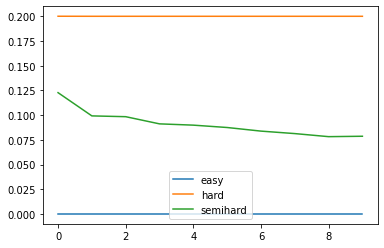

In [12]:
# A)
# B) 
# C)

class Net(nn.Module):
    def __init__(self, embedding_net):
        super(Net, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x):
        output = self.embedding_net(x)
        return output

    def get_embedding(self, x):
        return self.embedding_net(x)



        
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)


def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

    
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="easy")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

mean, std = 0.28604059698879553, 0.35302424451492237


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

dataset1 = FashionMNIST('.', train=True, download=True, transform=transform)
dataset2 = FashionMNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)


embedding_net = EmbeddingNet()

model = Net(embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for triplet in ["easy", "hard", "semihard"]:
    mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets=triplet)
    losses = []
    for epoch in range(1, num_epochs + 1):
        loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
        losses.append(loss)
        test(dataset1, dataset2, model, accuracy_calculator)
    
    plt.plot(losses, label=triplet)

plt.legend()
plt.show()

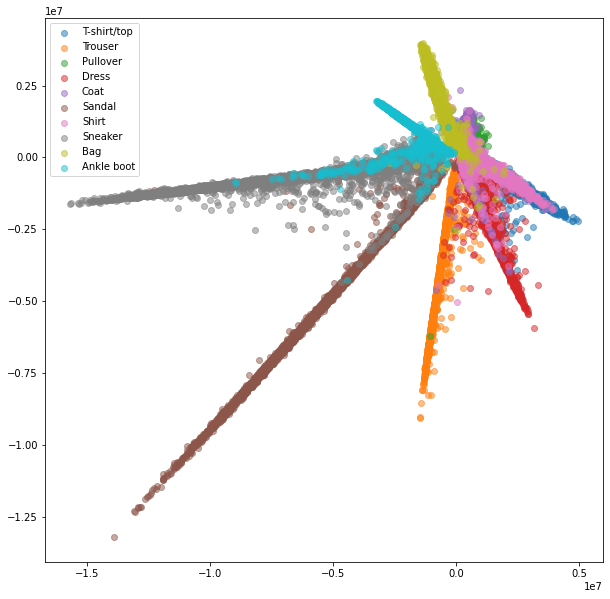

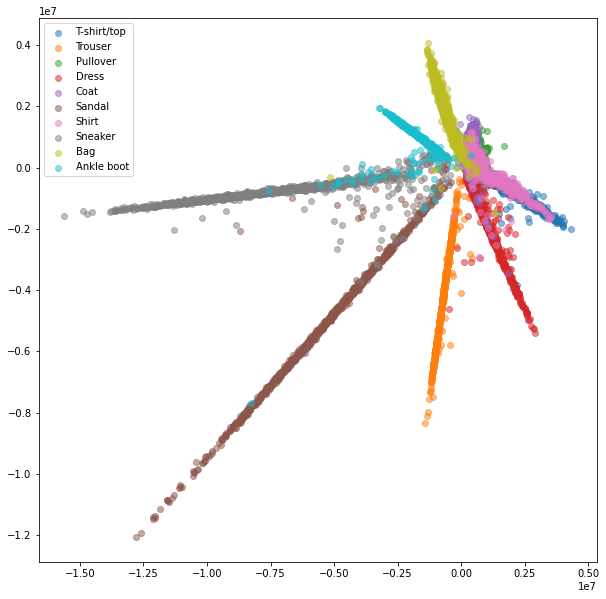

In [13]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [14]:
# D
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [15]:
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_components=2, verbose=1, n_jobs=2)

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68502 sha256=7ff33197c5e52c6ee5eaaa6b0770eaed58f59691d1e3f0e6e816df7a883f4438
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [16]:
dataset1 = FashionMNIST('.', train=True, download=True, transform=transform)
dataset2 = FashionMNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

embedding_net = EmbeddingNet()
model = Net(embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.1039738655090332, Number of mined triplets = 837289
Epoch 1 Iteration 20: Loss = 0.1100756898522377, Number of mined triplets = 149348
Epoch 1 Iteration 40: Loss = 0.09724556654691696, Number of mined triplets = 109249
Epoch 1 Iteration 60: Loss = 0.09810464829206467, Number of mined triplets = 80112
Epoch 1 Iteration 80: Loss = 0.09979812055826187, Number of mined triplets = 80022
Epoch 1 Iteration 100: Loss = 0.09604226797819138, Number of mined triplets = 81391
Epoch 1 Iteration 120: Loss = 0.09663215279579163, Number of mined triplets = 71891
Epoch 1 Iteration 140: Loss = 0.09696438163518906, Number of mined triplets = 67827
Epoch 1 Iteration 160: Loss = 0.09546750783920288, Number of mined triplets = 64516
Epoch 1 Iteration 180: Loss = 0.09470634907484055, Number of mined triplets = 57863
Epoch 1 Iteration 200: Loss = 0.09603259712457657, Number of mined triplets = 72951
Epoch 1 Iteration 220: Loss = 0.09176435321569443, Number of mined triplets = 542

100%|██████████| 313/313 [00:02<00:00, 113.65it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8467
Epoch 2 Iteration 0: Loss = 0.09533665329217911, Number of mined triplets = 66625
Epoch 2 Iteration 20: Loss = 0.09080416709184647, Number of mined triplets = 49183
Epoch 2 Iteration 40: Loss = 0.09590441733598709, Number of mined triplets = 70710
Epoch 2 Iteration 60: Loss = 0.09153741598129272, Number of mined triplets = 55962
Epoch 2 Iteration 80: Loss = 0.09310510754585266, Number of mined triplets = 65368
Epoch 2 Iteration 100: Loss = 0.09338884800672531, Number of mined triplets = 73563
Epoch 2 Iteration 120: Loss = 0.09146975725889206, Number of mined triplets = 55154
Epoch 2 Iteration 140: Loss = 0.09414338320493698, Number of mined triplets = 61151
Epoch 2 Iteration 160: Loss = 0.09099901467561722, Number of mined triplets = 39539
Epoch 2 Iteration 180: Loss = 0.09122641384601593, Number of mined triplets = 46691
Epoch 2 Iteration 200: Loss = 0.0917823389172554, Number of mined triplets = 47288
Epoch 2 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 114.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8685
Epoch 3 Iteration 0: Loss = 0.09356269985437393, Number of mined triplets = 63203
Epoch 3 Iteration 20: Loss = 0.09215570241212845, Number of mined triplets = 43332
Epoch 3 Iteration 40: Loss = 0.09106557071208954, Number of mined triplets = 47535
Epoch 3 Iteration 60: Loss = 0.09086522459983826, Number of mined triplets = 40400
Epoch 3 Iteration 80: Loss = 0.09291411936283112, Number of mined triplets = 69929
Epoch 3 Iteration 100: Loss = 0.09303370118141174, Number of mined triplets = 52055
Epoch 3 Iteration 120: Loss = 0.09213539212942123, Number of mined triplets = 38988
Epoch 3 Iteration 140: Loss = 0.08972923457622528, Number of mined triplets = 62916
Epoch 3 Iteration 160: Loss = 0.0911451205611229, Number of mined triplets = 37748
Epoch 3 Iteration 180: Loss = 0.09166855365037918, Number of mined triplets = 47763
Epoch 3 Iteration 200: Loss = 0.0905088409781456, Number of mined triplets = 42928
Epoch 3 Iteration 220: L

100%|██████████| 313/313 [00:02<00:00, 113.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8774000000000001
Epoch 4 Iteration 0: Loss = 0.09186483919620514, Number of mined triplets = 43762
Epoch 4 Iteration 20: Loss = 0.09171076118946075, Number of mined triplets = 54958
Epoch 4 Iteration 40: Loss = 0.09382269531488419, Number of mined triplets = 56685
Epoch 4 Iteration 60: Loss = 0.0903874933719635, Number of mined triplets = 40034
Epoch 4 Iteration 80: Loss = 0.09053192287683487, Number of mined triplets = 50666
Epoch 4 Iteration 100: Loss = 0.0914808139204979, Number of mined triplets = 56328
Epoch 4 Iteration 120: Loss = 0.08933612704277039, Number of mined triplets = 41396
Epoch 4 Iteration 140: Loss = 0.09030743688344955, Number of mined triplets = 43155
Epoch 4 Iteration 160: Loss = 0.08970104157924652, Number of mined triplets = 30865
Epoch 4 Iteration 180: Loss = 0.09254468232393265, Number of mined triplets = 55735
Epoch 4 Iteration 200: Loss = 0.09220319986343384, Number of mined triplets = 43991
Epoch 4 Iter

100%|██████████| 313/313 [00:02<00:00, 115.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8838
Epoch 5 Iteration 0: Loss = 0.09206346422433853, Number of mined triplets = 41853
Epoch 5 Iteration 20: Loss = 0.08996623009443283, Number of mined triplets = 36738
Epoch 5 Iteration 40: Loss = 0.08985329419374466, Number of mined triplets = 29605
Epoch 5 Iteration 60: Loss = 0.09267943352460861, Number of mined triplets = 47402
Epoch 5 Iteration 80: Loss = 0.09131961315870285, Number of mined triplets = 38700
Epoch 5 Iteration 100: Loss = 0.09163165837526321, Number of mined triplets = 43411
Epoch 5 Iteration 120: Loss = 0.09133334457874298, Number of mined triplets = 38725
Epoch 5 Iteration 140: Loss = 0.09185183793306351, Number of mined triplets = 41978
Epoch 5 Iteration 160: Loss = 0.09080538153648376, Number of mined triplets = 52427
Epoch 5 Iteration 180: Loss = 0.08964596688747406, Number of mined triplets = 31979
Epoch 5 Iteration 200: Loss = 0.09241435676813126, Number of mined triplets = 40284
Epoch 5 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 112.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.889
Epoch 6 Iteration 0: Loss = 0.09198137372732162, Number of mined triplets = 55905
Epoch 6 Iteration 20: Loss = 0.09216104447841644, Number of mined triplets = 42601
Epoch 6 Iteration 40: Loss = 0.08668432384729385, Number of mined triplets = 28839
Epoch 6 Iteration 60: Loss = 0.09108935296535492, Number of mined triplets = 34829
Epoch 6 Iteration 80: Loss = 0.09198624640703201, Number of mined triplets = 34136
Epoch 6 Iteration 100: Loss = 0.09086732566356659, Number of mined triplets = 36662
Epoch 6 Iteration 120: Loss = 0.09069932252168655, Number of mined triplets = 45757
Epoch 6 Iteration 140: Loss = 0.08884294331073761, Number of mined triplets = 39708
Epoch 6 Iteration 160: Loss = 0.09174291789531708, Number of mined triplets = 45898
Epoch 6 Iteration 180: Loss = 0.09333872050046921, Number of mined triplets = 47740
Epoch 6 Iteration 200: Loss = 0.09056160598993301, Number of mined triplets = 39170
Epoch 6 Iteration 220: 

100%|██████████| 313/313 [00:02<00:00, 114.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8859
Epoch 7 Iteration 0: Loss = 0.09110993146896362, Number of mined triplets = 25765
Epoch 7 Iteration 20: Loss = 0.08798366785049438, Number of mined triplets = 36914
Epoch 7 Iteration 40: Loss = 0.09018796682357788, Number of mined triplets = 41702
Epoch 7 Iteration 60: Loss = 0.08958736062049866, Number of mined triplets = 32406
Epoch 7 Iteration 80: Loss = 0.09213441610336304, Number of mined triplets = 46826
Epoch 7 Iteration 100: Loss = 0.09060611575841904, Number of mined triplets = 35627
Epoch 7 Iteration 120: Loss = 0.09164892137050629, Number of mined triplets = 46556
Epoch 7 Iteration 140: Loss = 0.09144556522369385, Number of mined triplets = 45196
Epoch 7 Iteration 160: Loss = 0.08938367664813995, Number of mined triplets = 39309
Epoch 7 Iteration 180: Loss = 0.09136181324720383, Number of mined triplets = 43608
Epoch 7 Iteration 200: Loss = 0.09074651449918747, Number of mined triplets = 28925
Epoch 7 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 114.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8868
Epoch 8 Iteration 0: Loss = 0.09168461710214615, Number of mined triplets = 38601
Epoch 8 Iteration 20: Loss = 0.09021241962909698, Number of mined triplets = 40367
Epoch 8 Iteration 40: Loss = 0.09015019237995148, Number of mined triplets = 42371
Epoch 8 Iteration 60: Loss = 0.08808240294456482, Number of mined triplets = 29577
Epoch 8 Iteration 80: Loss = 0.0887356624007225, Number of mined triplets = 38878
Epoch 8 Iteration 100: Loss = 0.09124630689620972, Number of mined triplets = 43824
Epoch 8 Iteration 120: Loss = 0.08973634243011475, Number of mined triplets = 44616
Epoch 8 Iteration 140: Loss = 0.08709685504436493, Number of mined triplets = 24781
Epoch 8 Iteration 160: Loss = 0.08962003886699677, Number of mined triplets = 31615
Epoch 8 Iteration 180: Loss = 0.08966371417045593, Number of mined triplets = 38404
Epoch 8 Iteration 200: Loss = 0.0909506231546402, Number of mined triplets = 44863
Epoch 8 Iteration 220: L

100%|██████████| 313/313 [00:02<00:00, 116.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8921
Epoch 9 Iteration 0: Loss = 0.0907440260052681, Number of mined triplets = 45323
Epoch 9 Iteration 20: Loss = 0.0903952345252037, Number of mined triplets = 35632
Epoch 9 Iteration 40: Loss = 0.0903649777173996, Number of mined triplets = 42048
Epoch 9 Iteration 60: Loss = 0.09073692560195923, Number of mined triplets = 24693
Epoch 9 Iteration 80: Loss = 0.09077439457178116, Number of mined triplets = 40317
Epoch 9 Iteration 100: Loss = 0.09128889441490173, Number of mined triplets = 46319
Epoch 9 Iteration 120: Loss = 0.08768525719642639, Number of mined triplets = 28469
Epoch 9 Iteration 140: Loss = 0.09160106629133224, Number of mined triplets = 37869
Epoch 9 Iteration 160: Loss = 0.09063305705785751, Number of mined triplets = 33776
Epoch 9 Iteration 180: Loss = 0.09058613330125809, Number of mined triplets = 39733
Epoch 9 Iteration 200: Loss = 0.08959802240133286, Number of mined triplets = 33860
Epoch 9 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 112.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8888
Epoch 10 Iteration 0: Loss = 0.09062720835208893, Number of mined triplets = 36111
Epoch 10 Iteration 20: Loss = 0.08930093050003052, Number of mined triplets = 30989
Epoch 10 Iteration 40: Loss = 0.08951882272958755, Number of mined triplets = 48249
Epoch 10 Iteration 60: Loss = 0.08914951235055923, Number of mined triplets = 29453
Epoch 10 Iteration 80: Loss = 0.08940233290195465, Number of mined triplets = 31611
Epoch 10 Iteration 100: Loss = 0.0915021002292633, Number of mined triplets = 47108
Epoch 10 Iteration 120: Loss = 0.08961619436740875, Number of mined triplets = 40093
Epoch 10 Iteration 140: Loss = 0.08991549909114838, Number of mined triplets = 27549
Epoch 10 Iteration 160: Loss = 0.09241468459367752, Number of mined triplets = 54759
Epoch 10 Iteration 180: Loss = 0.08806375414133072, Number of mined triplets = 30787
Epoch 10 Iteration 200: Loss = 0.08886764198541641, Number of mined triplets = 35020
Epoch 10 Ite

100%|██████████| 313/313 [00:02<00:00, 113.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8939


100%|██████████| 313/313 [00:02<00:00, 114.40it/s]


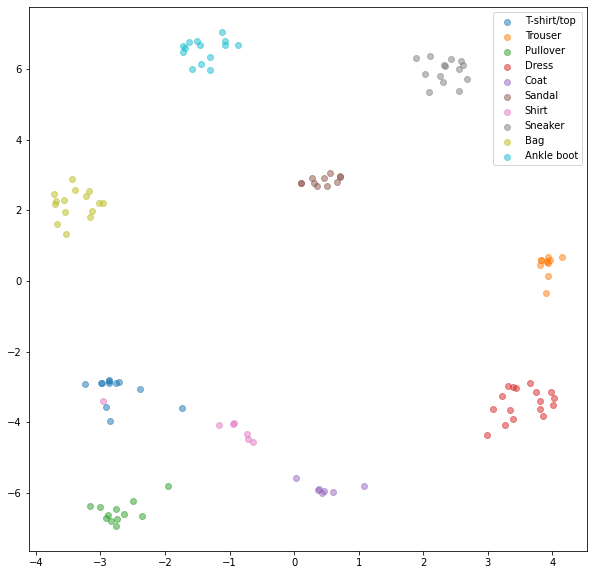

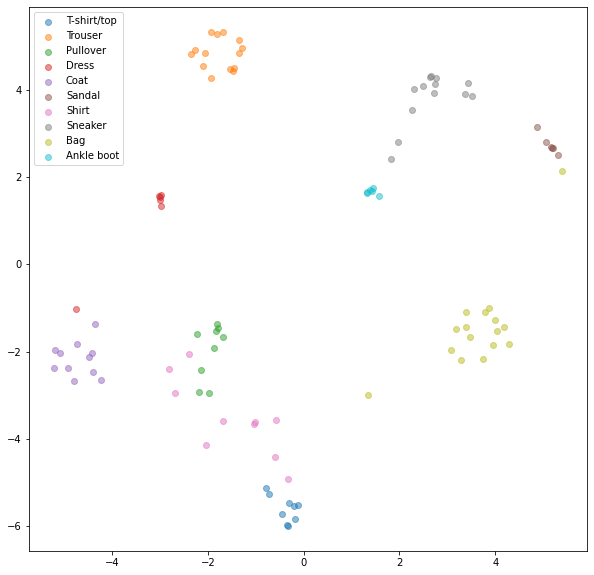

In [17]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

train_embeddings = tsne.fit_transform(train_embeddings[::500].cpu())

plot_embeddings(train_embeddings, train_labels[::500].cpu())
val_embeddings_baseline, val_labels_baseline = get_all_embeddings(dataset2, model)
val_embeddings_baseline = tsne.fit_transform(val_embeddings_baseline[::100].cpu())

plot_embeddings(val_embeddings_baseline, val_labels_baseline[::100].cpu())